# Transfer Learning on Kenyan Sign Language

In [1]:
# set the python env so that we can use the project utils
import sys
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import backend as K
from tqdm import tqdm

K.clear_session()


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-02-06 09:14:03.063158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738826043.662228    1194 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738826043.810703    1194 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 09:14:04.967616: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


## Load Dataset

The dataset is structured into folders. Each folder has the name of the `label` and contains all relevant `images` of this label.

Train and Test set are also found into two separate folders.

This allows us to use the `image_dataset_from_directory` method from keras to quickly load the datase.

We __normalize__ the dataset and split it into:

- train set
- validation set (15% of the train set)
- test set


In [2]:
# A quick check to find the dimentionality of the images
from PIL import Image

img = Image.open("../../sign_datasets/kslc-kenyan-sign-language-dataset/test/Church/ImageID_0D69ZQ4X.jpg")

print(f'Image dimentions: {img.size}')

Image dimentions: (512, 512)


In [3]:
train_dataset_path = "../../sign_datasets/kslc-kenyan-sign-language-dataset/train"
test_dataset_path = "../../sign_datasets/kslc-kenyan-sign-language-dataset/test"

train_dataset, val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset_path,
    # No resize needed, image is already 224, 244
    image_size=(224, 224),
    batch_size=16,
    validation_split=0.15,
    shuffle=True,
    seed=42,
    subset="both",
)

# The test dataset is under the test folder
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset_path,
    # No resize needed, image is already 224, 244
    image_size=(224, 224),
    batch_size=16,
    shuffle=True,
)


def normalize_image(image, label):
    precomputed_mean = [0.6287722587585449, 0.6092960834503174, 0.5825445055961609]
    precomputed_std = [0.6499956250190735, 0.6389758586883545, 0.6195625066757202]

    # Normalize the image
    image = (image / 255.0 - precomputed_mean) / precomputed_std
    return image, label


train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

print(
    f"Train size: {train_dataset.cardinality().numpy()}. Validation size will be: {val_dataset.cardinality().numpy()}"
)

# Set performance settings
# Prefetch one batch at a time
buffer_size = 1
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
val_dataset = val_dataset.prefetch(buffer_size=buffer_size)
test_dataset = test_dataset.prefetch(buffer_size=buffer_size)


Found 4999 files belonging to 9 classes.
Using 4250 files for training.
Using 749 files for validation.


I0000 00:00:1738427173.593404   13289 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2859 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Found 1250 files belonging to 9 classes.
Train size: 266. Validation size will be: 47


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9402514..0.5583402].


(16, 224, 224, 3)


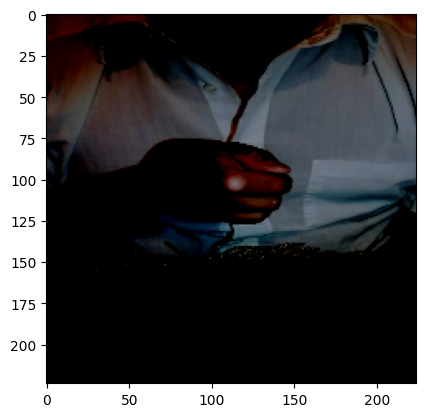

In [4]:
# Print a random image to make sure it's properly shown
images, labels = next(iter(train_dataset))

print(images.shape)

plt.imshow(images[0, :, :, :])
plt.show()

## Helper Methods

The following methods aim to make the code easier

In [6]:
from sklearn.metrics import confusion_matrix


def get_class_count(dataset):
    """Find out how many elements bellong to each class
    This method is used in plot_class_distribution to plot
    the distribution of the data
    
    Return:
        class_counts: A dictionary with the class name as a key
        and the total items as a value
    """
    class_counts = {}
    for images, labels in tqdm(dataset):
        for label in labels:
            # Here the label is a tensor with 1 element
            # We have to convert it to numpy
            label = label.numpy()
            # Count it
            class_counts[label] = class_counts.get(label, 0) + 1
    # Return the counts
    return class_counts

def plot_class_distribution(dataset, title: str):
    """Get how many elements belong to each class and plot them
    
    This method can help us see if there is an inbalance in the data
    """
    # Get the class counts
    class_counts = get_class_count(dataset)

    # greate an index for the dataframe
    index = list(range(len(class_counts)))
    # Create a dataframe
    df = pd.DataFrame(class_counts, index=index)
    
    # Set the figure size
    plt.figure(figsize=(12, 6))
    # Add the data
    ax = sns.barplot(df)
    # Set the title
    ax.set_title(title)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    # Adjust layout to make room for rotated labels
    plt.tight_layout()
    plt.show()

def plot_history(history):
    """Plot the history returned by the training
    """

    # Convert history to a DataFrame
    history_df = pd.DataFrame(history.history)

    # Create a single figure with two subplots
    fig, ax1 = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plotting training and validation loss
    sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax1[0])
    ax1[0].set_title('Model Loss')
    ax1[0].set_xlabel('Epochs')
    ax1[0].set_ylabel('Loss')
    ax1[0].legend(['Train', 'Validation'])
    
    # Plotting training and validation accuracy
    sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=ax1[1])
    ax1[1].set_title('Model Accuracy')
    ax1[1].set_xlabel('Epochs')
    ax1[1].set_ylabel('Accuracy')
    ax1[1].legend(['Train', 'Validation'])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## Visualizations

Bellow we can see some visualizations for this dataset

100%|██████████| 266/266 [00:08<00:00, 32.92it/s]


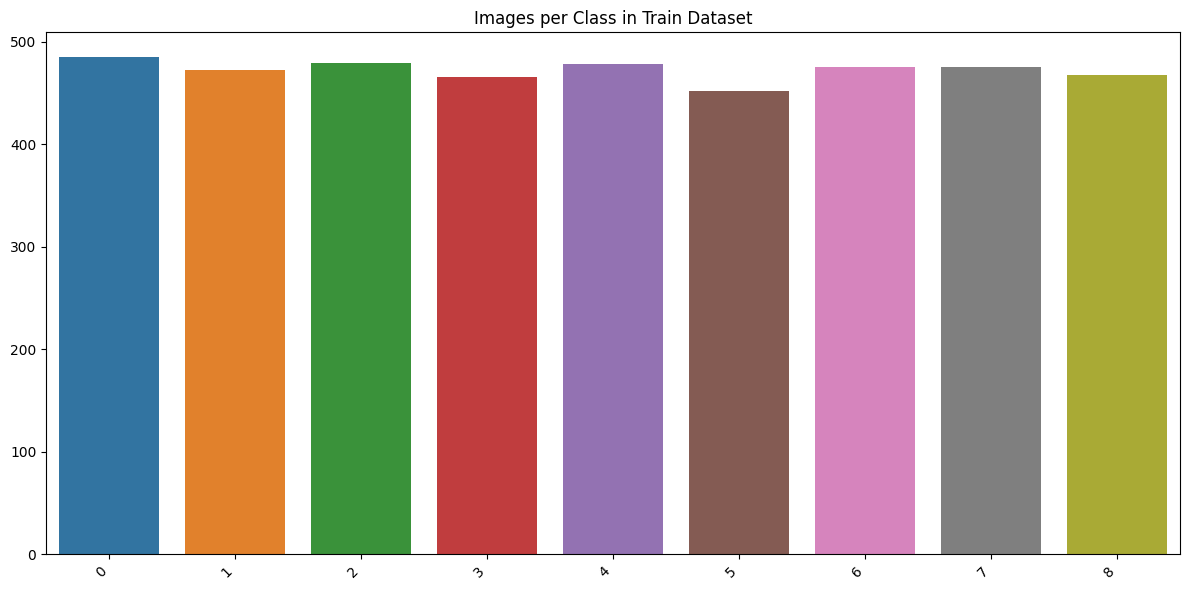

In [6]:
plot_class_distribution(train_dataset, "Images per Class in Train Dataset")

100%|██████████| 47/47 [00:02<00:00, 18.10it/s]


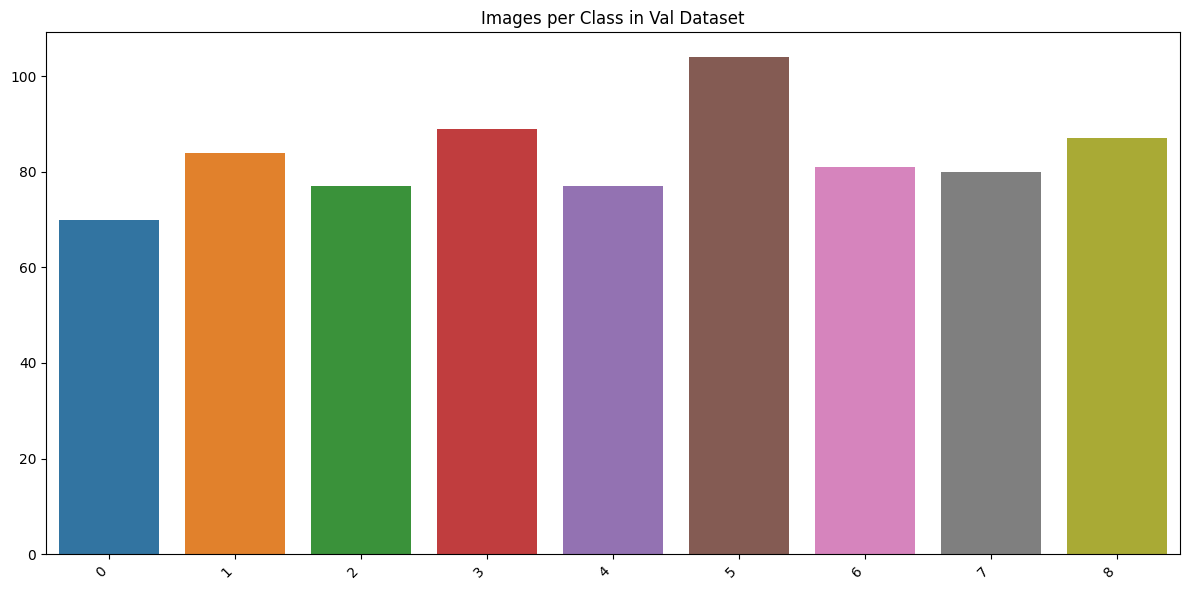

In [7]:
plot_class_distribution(val_dataset, "Images per Class in Val Dataset")

100%|██████████| 79/79 [00:02<00:00, 28.35it/s]


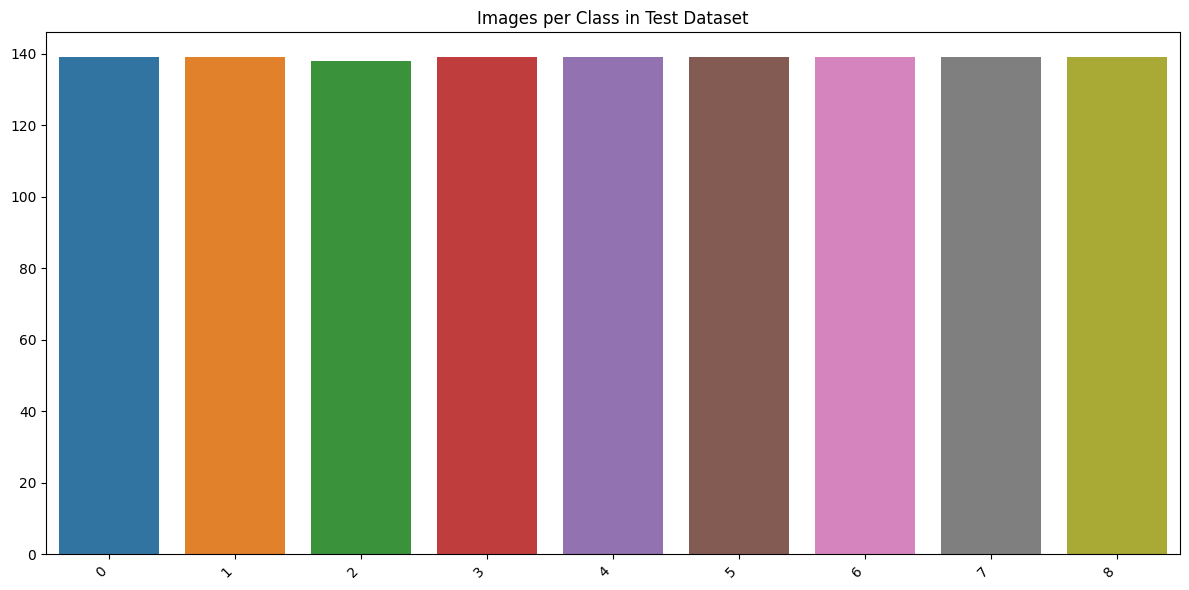

In [8]:
plot_class_distribution(test_dataset, "Images per Class in Test Dataset")

## Extract Class Names

In [3]:
def get_class_names(test_dataset, verbose: bool = False):
    class_names = set()

    for _, labels in tqdm(test_dataset, desc="Gathering Labels"):
        for label in labels:
            class_names.add(int(label))

    if verbose:
        print(f"Unique Dataset Labels: {class_names}")

    return class_names

In [4]:
class_names = get_class_names(test_dataset=test_dataset, verbose=True)

Gathering Labels:   0%|          | 0/313 [00:00<?, ?it/s]

Gathering Labels: 100%|██████████| 313/313 [00:07<00:00, 43.49it/s]

Unique Dataset Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8}


## MobileNet Transfer Learning

Let's try to finetune `MobileNetV2` for our task.

MobileNetV2 is trained on the `imagenet` dataset.

Due to the fact that it works with some specific image sizes, we have have reshaped our images to (224, 244)

We will try __different hidden sizes__ with __3 epochs__, using a __dropout__ of 0.4

---------------------------
---------------------------
HIDDEN SIZE: 128
---------------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,625 (9.25 MB)

 Trainable params: 165,385 (646.04 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

None
Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.3177 - loss: 2.0543 - val_accuracy: 0.5928 - val_loss: 1.1891
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.6058 - loss: 1.1223 - val_accuracy: 0.6155 - val_loss: 1.0925
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.6692 - loss: 0.9293 - val_accuracy: 0.6315 - val_loss: 1.0575
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.7053 - loss: 0.8085 - val_accuracy: 0.6275 - val_loss: 1.0660
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.7464 - loss: 0.7239 - val_accuracy: 0.6449 - val_loss: 1.0446
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.7892 - loss: 0.6353 - val_accuracy: 0.6195 - val_loss: 1.1042
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.7987 - loss: 0.5673 - val_accuracy: 0.6315 - val_loss: 1.0870
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8206 - loss: 0.5

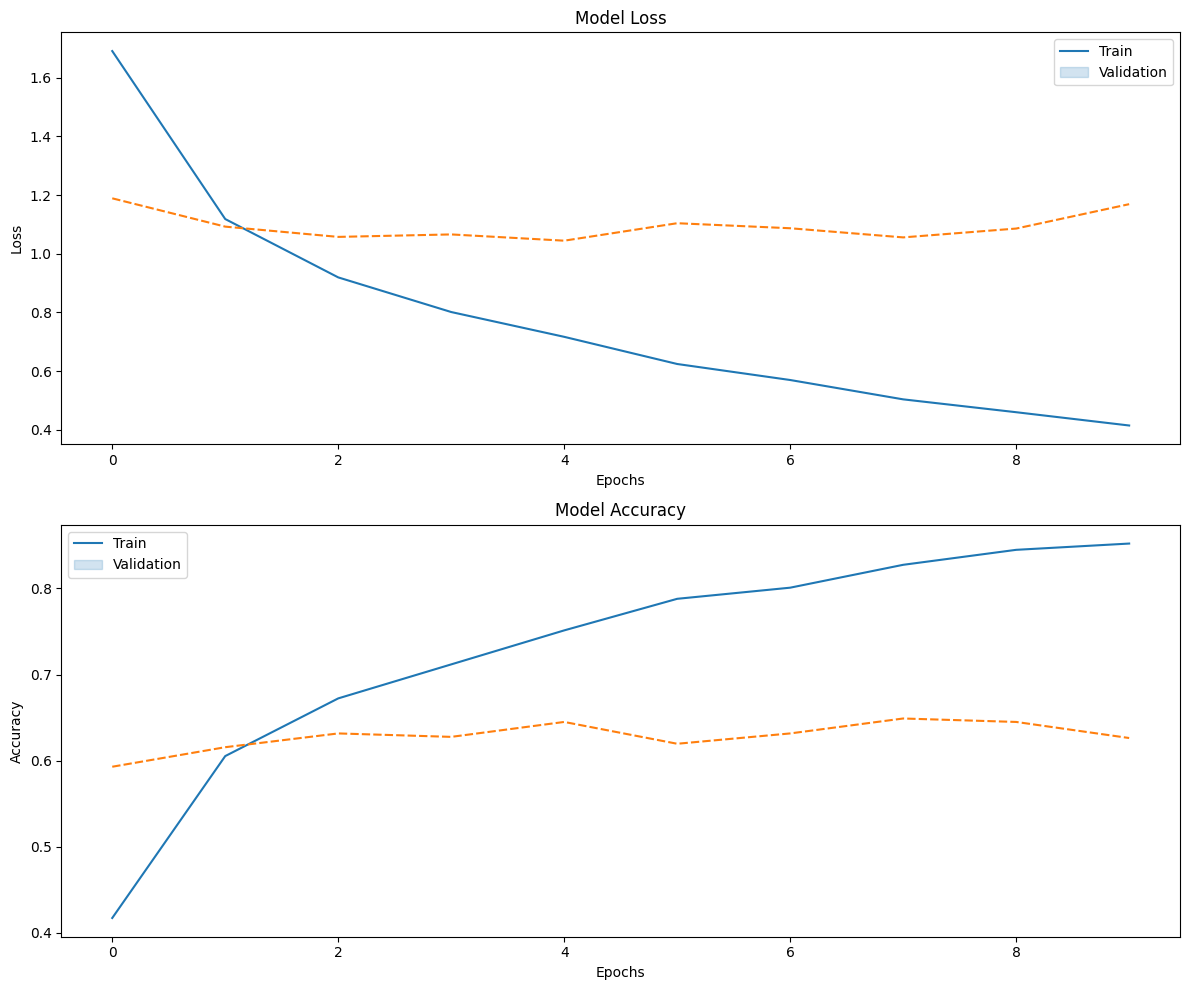

---------------------------
---------------------------
HIDDEN SIZE: 256
---------------------------


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,257 (9.88 MB)

 Trainable params: 330,761 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

None
Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.3557 - loss: 1.8922 - val_accuracy: 0.5648 - val_loss: 1.1822
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.6629 - loss: 0.9906 - val_accuracy: 0.6008 - val_loss: 1.0961
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.7167 - loss: 0.8291 - val_accuracy: 0.6182 - val_loss: 1.0651
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.7699 - loss: 0.6916 - val_accuracy: 0.6168 - val_loss: 1.0952
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.8144 - loss: 0.5520 - val_accuracy: 0.6262 - val_loss: 1.0780
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.8285 - loss: 0.4920 - val_accuracy: 0.6342 - val_loss: 1.1440
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.8747 - loss: 0.3906 - val_accuracy: 0.6115 - val_loss: 1.1811
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.8764 - loss: 0.36

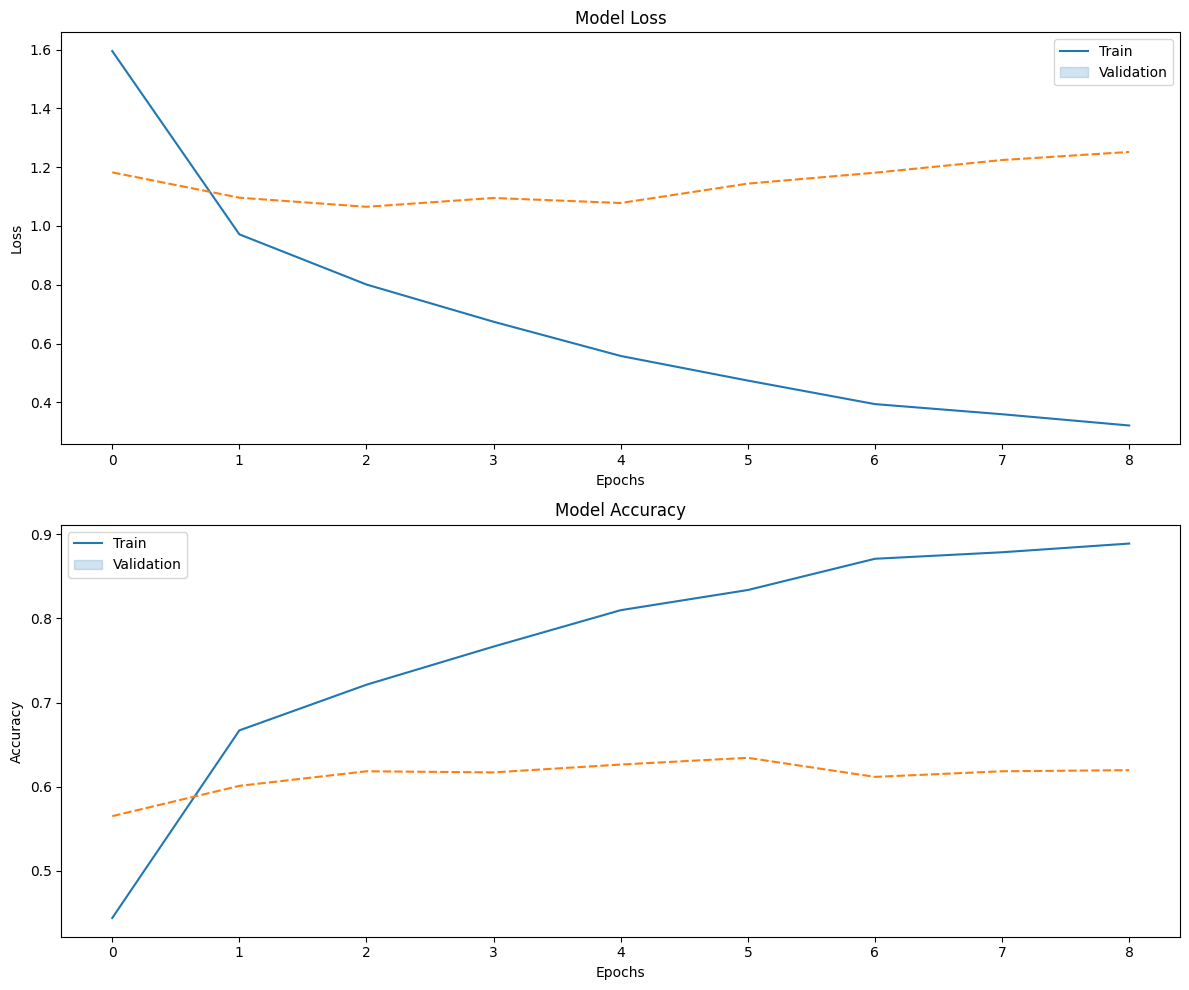

---------------------------
---------------------------
HIDDEN SIZE: 512
---------------------------


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,920,521 (11.14 MB)

 Trainable params: 661,513 (2.52 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

None
Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.3879 - loss: 1.8883 - val_accuracy: 0.5915 - val_loss: 1.2076
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.6763 - loss: 0.9145 - val_accuracy: 0.6142 - val_loss: 1.0958
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.7574 - loss: 0.7063 - val_accuracy: 0.6222 - val_loss: 1.0958
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.8052 - loss: 0.5575 - val_accuracy: 0.6222 - val_loss: 1.1599
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8598 - loss: 0.4395 - val_accuracy: 0.6075 - val_loss: 1.2410
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8611 - loss: 0.3909 - val_accuracy: 0.5915 - val_loss: 1.3393


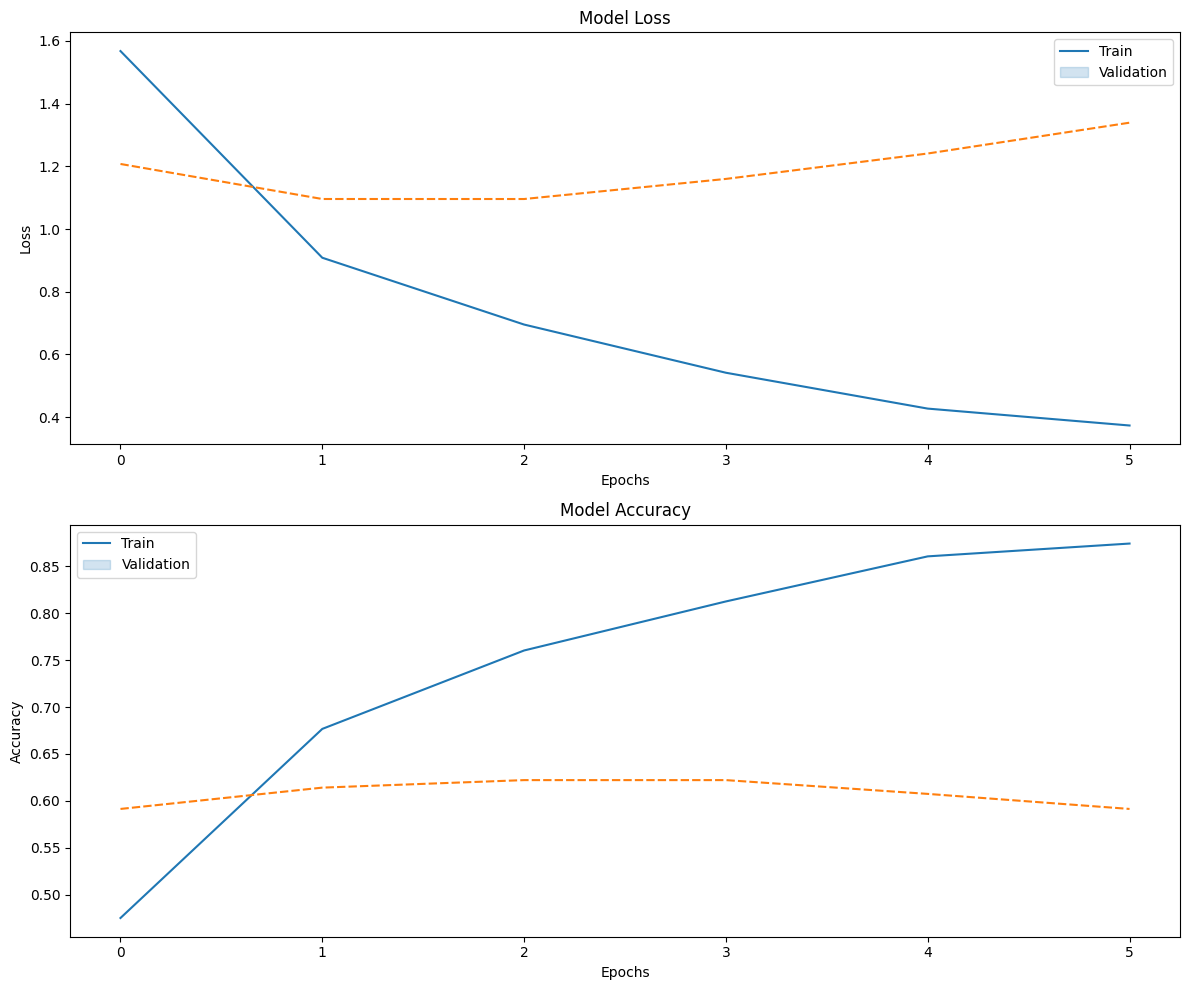

79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.6565 - loss: 1.1114
Test Loss: 1.0879006385803223
Test Accuracy: 0.656000018119812


In [13]:
hidden_sizes = [128, 256, 512]
best_model = None
best_acc = -1

# early stopping callback
# patience of 3 since we have a small number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=3,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

for hidden_size in hidden_sizes:

    print('---------------------------')
    print('---------------------------')
    print(f'HIDDEN SIZE: {hidden_size}')
    print('---------------------------')

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )
    # we dont want to train the base model
    base_model.trainable = False

    
    # Add custom layers on top of the base model
    model = tf.keras.Sequential(
        [
            base_model,
            # This is added to reduce the number of parameters
            tf.keras.layers.GlobalAveragePooling2D(),
            # Add our custom hidden size
            tf.keras.layers.Dense(hidden_size, activation=None),
            # Use a batch normalization layer
            tf.keras.layers.BatchNormalization(),
            # Then the relu
            tf.keras.layers.Activation("relu"),
            # Dropout of 0.3
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(len(class_names), activation="softmax"),
        ]
    )
    
    print(model.summary())
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])

    # make sure to keep the best model
    if best_model is None or history.history['val_accuracy'][-1] > best_acc:
        print('New best model found')
        best_model = model
        best_acc = history.history['val_accuracy'][-1]

    # plot two graphs, one for the train / val loss and one for the train / val accuracy
    plot_history(history)


# Finally inference with the best model
results = best_model.evaluate(test_dataset)

print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

## Confusion Matrix

  0%|          | 0/79 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


  1%|▏         | 1/79 [00:04<06:13,  4.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


  3%|▎         | 2/79 [00:04<02:40,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


  4%|▍         | 3/79 [00:05<01:33,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  5%|▌         | 4/79 [00:05<01:05,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  6%|▋         | 5/79 [00:05<00:46,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


  8%|▊         | 6/79 [00:05<00:34,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


  9%|▉         | 7/79 [00:06<00:27,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 10%|█         | 8/79 [00:06<00:22,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 11%|█▏        | 9/79 [00:06<00:20,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 13%|█▎        | 10/79 [00:06<00:17,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 14%|█▍        | 11/79 [00:06<00:16,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 15%|█▌        | 12/79 [00:07<00:15,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 16%|█▋        | 13/79 [00:07<00:14,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 18%|█▊        | 14/79 [00:07<00:14,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 19%|█▉        | 15/79 [00:07<00:14,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 20%|██        | 16/79 [00:07<00:13,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 22%|██▏       | 17/79 [00:08<00:12,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 23%|██▎       | 18/79 [00:08<00:12,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 24%|██▍       | 19/79 [00:08<00:12,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 25%|██▌       | 20/79 [00:08<00:11,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 27%|██▋       | 21/79 [00:09<00:13,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 28%|██▊       | 22/79 [00:09<00:12,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 29%|██▉       | 23/79 [00:09<00:12,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 30%|███       | 24/79 [00:09<00:12,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 32%|███▏      | 25/79 [00:09<00:11,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 33%|███▎      | 26/79 [00:10<00:11,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 34%|███▍      | 27/79 [00:10<00:10,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 35%|███▌      | 28/79 [00:10<00:10,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 37%|███▋      | 29/79 [00:10<00:10,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 38%|███▊      | 30/79 [00:10<00:09,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 39%|███▉      | 31/79 [00:11<00:10,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 41%|████      | 32/79 [00:11<00:10,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 42%|████▏     | 33/79 [00:11<00:09,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 43%|████▎     | 34/79 [00:11<00:09,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 44%|████▍     | 35/79 [00:11<00:09,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 46%|████▌     | 36/79 [00:12<00:08,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 47%|████▋     | 37/79 [00:12<00:08,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 48%|████▊     | 38/79 [00:12<00:10,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 49%|████▉     | 39/79 [00:12<00:09,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 51%|█████     | 40/79 [00:13<00:08,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 52%|█████▏    | 41/79 [00:13<00:08,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 53%|█████▎    | 42/79 [00:13<00:08,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 54%|█████▍    | 43/79 [00:13<00:07,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 56%|█████▌    | 44/79 [00:13<00:07,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 57%|█████▋    | 45/79 [00:14<00:07,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 58%|█████▊    | 46/79 [00:14<00:06,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 59%|█████▉    | 47/79 [00:14<00:06,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 61%|██████    | 48/79 [00:14<00:06,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 62%|██████▏   | 49/79 [00:14<00:06,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 63%|██████▎   | 50/79 [00:15<00:05,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 65%|██████▍   | 51/79 [00:15<00:06,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 66%|██████▌   | 52/79 [00:15<00:06,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 67%|██████▋   | 53/79 [00:15<00:05,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 68%|██████▊   | 54/79 [00:16<00:05,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 70%|██████▉   | 55/79 [00:16<00:04,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 71%|███████   | 56/79 [00:16<00:04,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 72%|███████▏  | 57/79 [00:16<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 73%|███████▎  | 58/79 [00:16<00:04,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 75%|███████▍  | 59/79 [00:17<00:04,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 76%|███████▌  | 60/79 [00:17<00:04,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 77%|███████▋  | 61/79 [00:17<00:04,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 78%|███████▊  | 62/79 [00:17<00:03,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 80%|███████▉  | 63/79 [00:18<00:03,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 81%|████████  | 64/79 [00:18<00:03,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 82%|████████▏ | 65/79 [00:18<00:02,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 84%|████████▎ | 66/79 [00:18<00:02,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 85%|████████▍ | 67/79 [00:18<00:02,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 86%|████████▌ | 68/79 [00:19<00:02,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 87%|████████▋ | 69/79 [00:19<00:02,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 89%|████████▊ | 70/79 [00:19<00:01,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 90%|████████▉ | 71/79 [00:19<00:01,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 91%|█████████ | 72/79 [00:19<00:01,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 92%|█████████▏| 73/79 [00:20<00:01,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 94%|█████████▎| 74/79 [00:20<00:00,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 95%|█████████▍| 75/79 [00:20<00:00,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 96%|█████████▌| 76/79 [00:20<00:00,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|█████████▋| 77/79 [00:20<00:00,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 99%|█████████▊| 78/79 [00:21<00:00,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


100%|██████████| 79/79 [00:24<00:00,  3.23it/s]


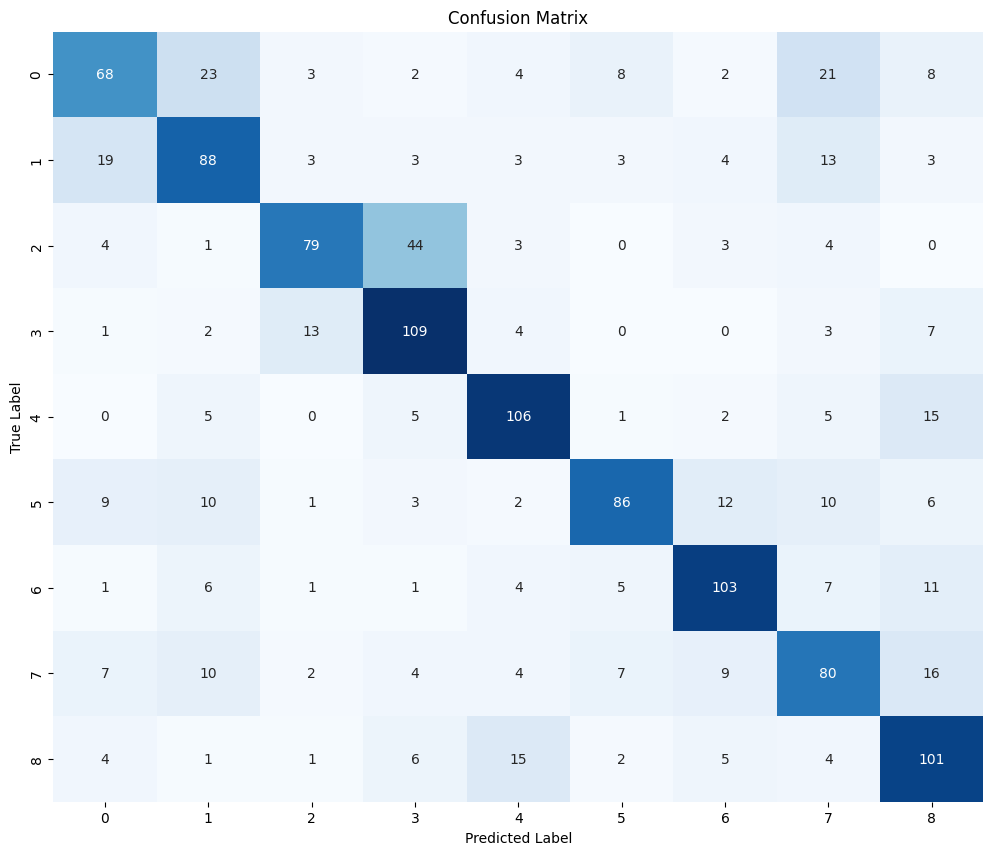

In [14]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = best_model.predict(x_batch)

    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(y_batch.numpy())

plot_confusion_matrix(y_true, y_pred, classes=class_names)

## ConvNeXtBase Transfer Learning

Let's try to finetune `ConvNeXtBase` for our task.

`ConvNeXtBase` is trained on the `imagenet` dataset

---------------------------
---------------------------
HIDDEN SIZE: 128
---------------------------


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,699,337 (334.55 MB)

 Trainable params: 132,617 (518.04 KB)

 Non-trainable params: 87,566,720 (334.04 MB)

None
Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 181s 565ms/step - accuracy: 0.2974 - loss: 2.0843 - val_accuracy: 0.5113 - val_loss: 1.3927
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 130s 489ms/step - accuracy: 0.5522 - loss: 1.2410 - val_accuracy: 0.5354 - val_loss: 1.2968
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 130s 487ms/step - accuracy: 0.6312 - loss: 1.0413 - val_accuracy: 0.5634 - val_loss: 1.2207
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 130s 488ms/step - accuracy: 0.6758 - loss: 0.9520 - val_accuracy: 0.5928 - val_loss: 1.1528
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 129s 485ms/step - accuracy: 0.7060 - loss: 0.8409 - val_accuracy: 0.5274 - val_loss: 1.2989
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 129s 487ms/step - accuracy: 0.7265 - loss: 0.7870 - val_accuracy: 0.5100 - val_loss: 1.4080
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 129s 486ms/step - accuracy: 0.7442 - loss: 0.7358 - val_accuracy: 0.5661 - val_loss: 1.2580
New best model found


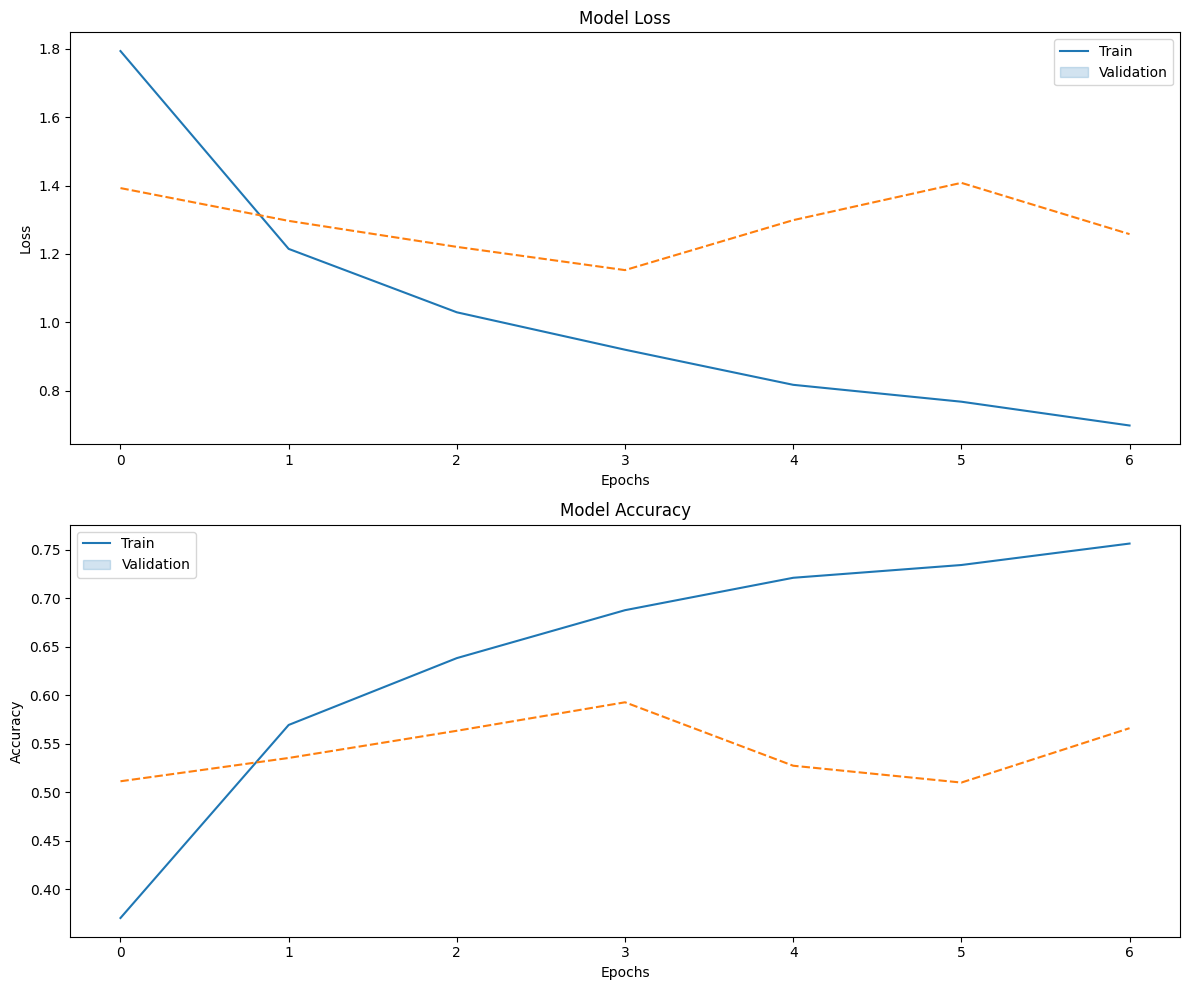

---------------------------
---------------------------
HIDDEN SIZE: 256
---------------------------


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,832,201 (335.05 MB)

 Trainable params: 265,225 (1.01 MB)

 Non-trainable params: 87,566,976 (334.04 MB)

None
Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 175s 555ms/step - accuracy: 0.3051 - loss: 2.0153 - val_accuracy: 0.5060 - val_loss: 1.3582
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 132s 496ms/step - accuracy: 0.5808 - loss: 1.1480 - val_accuracy: 0.5300 - val_loss: 1.3071
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 133s 502ms/step - accuracy: 0.6663 - loss: 0.9553 - val_accuracy: 0.5621 - val_loss: 1.2332
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 129s 485ms/step - accuracy: 0.7044 - loss: 0.8337 - val_accuracy: 0.5955 - val_loss: 1.1816
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 129s 485ms/step - accuracy: 0.7509 - loss: 0.7308 - val_accuracy: 0.5741 - val_loss: 1.2815
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 129s 484ms/step - accuracy: 0.7561 - loss: 0.7014 - val_accuracy: 0.5714 - val_loss: 1.2780
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 129s 483ms/step - accuracy: 0.7886 - loss: 0.6140 - val_accuracy: 0.5541 - val_loss: 1.5261


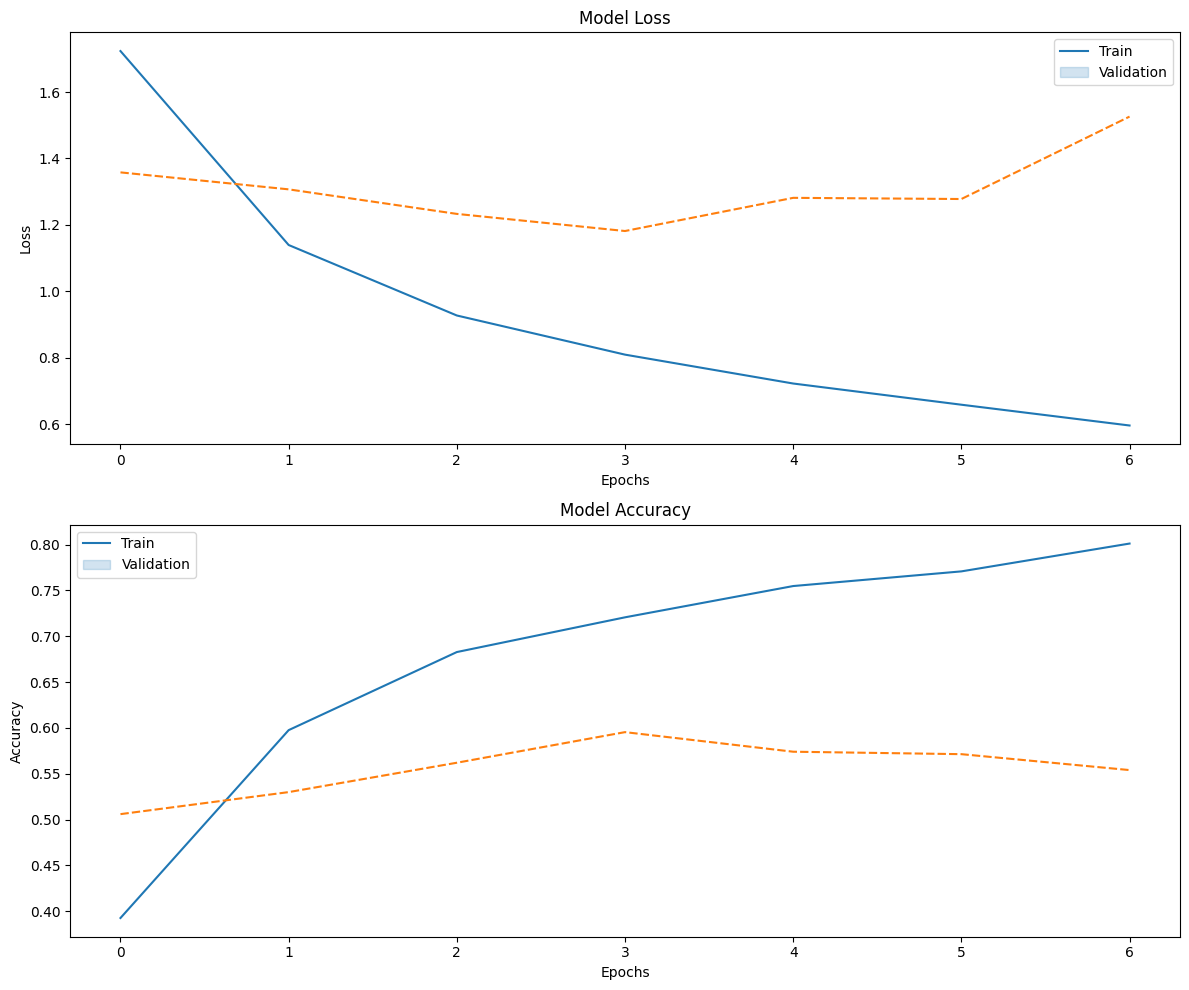

---------------------------
---------------------------
HIDDEN SIZE: 512
---------------------------


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,097,929 (336.07 MB)

 Trainable params: 530,441 (2.02 MB)

 Non-trainable params: 87,567,488 (334.04 MB)

None
Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 188s 613ms/step - accuracy: 0.3513 - loss: 1.9265 - val_accuracy: 0.5354 - val_loss: 1.3922
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 131s 493ms/step - accuracy: 0.6299 - loss: 1.0652 - val_accuracy: 0.4846 - val_loss: 1.5679
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 132s 495ms/step - accuracy: 0.7025 - loss: 0.8655 - val_accuracy: 0.5501 - val_loss: 1.3726
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 130s 490ms/step - accuracy: 0.7535 - loss: 0.7225 - val_accuracy: 0.5781 - val_loss: 1.3737
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 133s 502ms/step - accuracy: 0.7704 - loss: 0.6636 - val_accuracy: 0.5781 - val_loss: 1.3146
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 131s 491ms/step - accuracy: 0.7846 - loss: 0.6194 - val_accuracy: 0.5701 - val_loss: 1.4260
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 133s 500ms/step - accuracy: 0.8166 - loss: 0.5179 - val_accuracy: 0.5794 - val_loss: 1.4508
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 131s 491ms/step - accuracy: 0.8

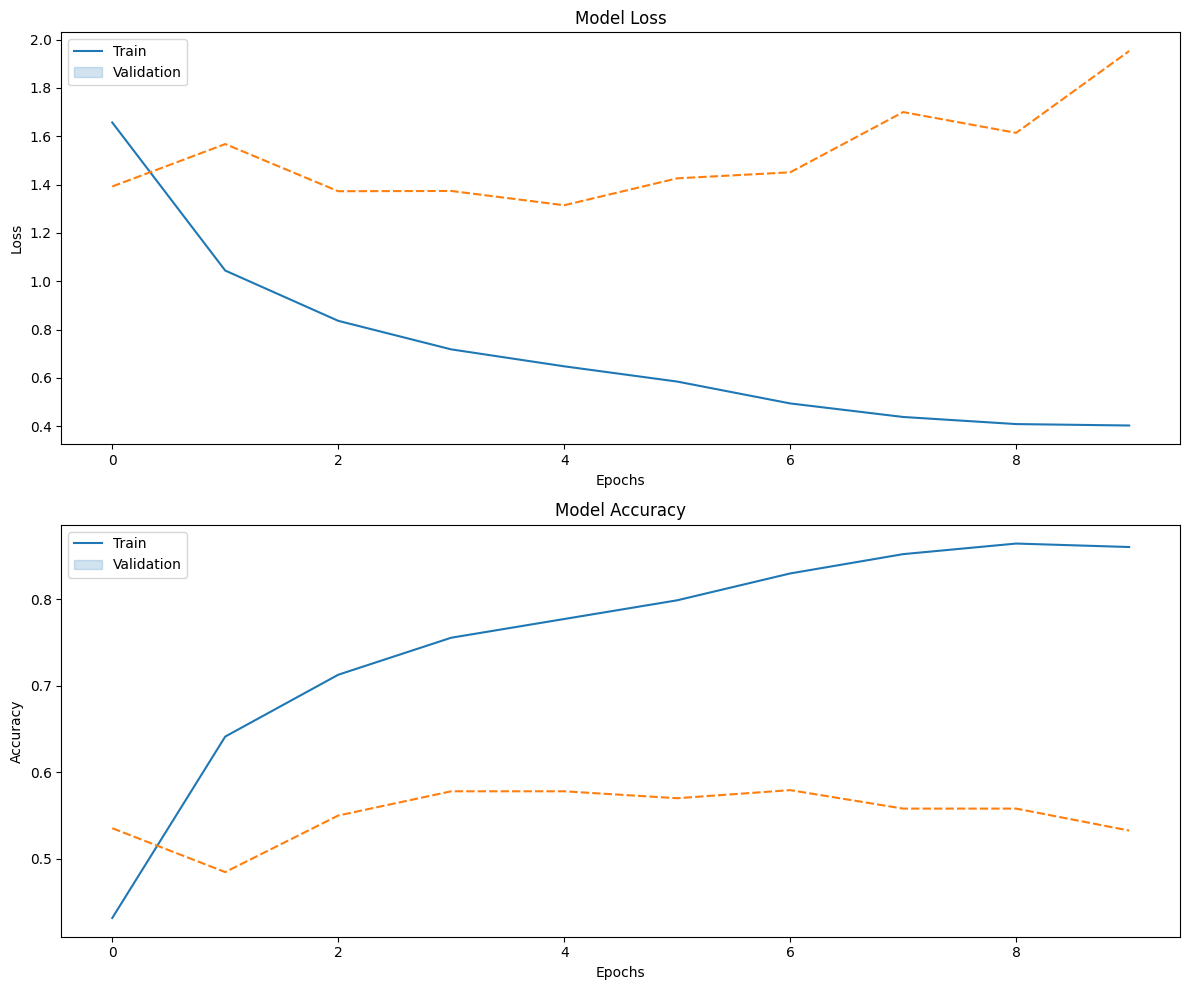

79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 477ms/step - accuracy: 0.5900 - loss: 1.2030
Test Loss: 1.1951680183410645
Test Accuracy: 0.5856000185012817


In [15]:
hidden_sizes = [128, 256, 512]
best_model = None
best_acc = -1

# early stopping callback
# patience of 3 since we have a small number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=3,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

for hidden_size in hidden_sizes:

    print('---------------------------')
    print('---------------------------')
    print(f'HIDDEN SIZE: {hidden_size}')
    print('---------------------------')

    base_model = tf.keras.applications.ConvNeXtBase(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )
    # we dont want to train the base model
    base_model.trainable = False

    # Add custom layers on top of the base model
    model = tf.keras.Sequential(
        [
            base_model,
            # This is added to reduce the number of parameters
            tf.keras.layers.GlobalAveragePooling2D(),
            # Add our custom hidden size
            tf.keras.layers.Dense(hidden_size, activation=None),
            # Use a batch normalization layer
            tf.keras.layers.BatchNormalization(),
            # Then the relu
            tf.keras.layers.Activation("relu"),
            # Dropout of 0.3
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(len(class_names), activation="softmax"),
        ]
    )
    
    print(model.summary())
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])

    # make sure to keep the best model
    if best_model is None or history.history['val_accuracy'][-1] > best_acc:
        print('New best model found')
        best_model = model
        best_acc = history.history['val_accuracy'][-1]

    # plot two graphs, one for the train / val loss and one for the train / val accuracy
    plot_history(history)

# Finally inference with the best model
results = best_model.evaluate(test_dataset)

print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

## Confusion Matrix

  0%|          | 0/79 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


  1%|▏         | 1/79 [00:06<08:47,  6.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


  3%|▎         | 2/79 [00:07<03:57,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


  4%|▍         | 3/79 [00:07<02:24,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


  5%|▌         | 4/79 [00:08<01:41,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


  6%|▋         | 5/79 [00:08<01:16,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


  8%|▊         | 6/79 [00:09<01:02,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


  9%|▉         | 7/79 [00:09<00:55,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 10%|█         | 8/79 [00:10<00:48,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 11%|█▏        | 9/79 [00:10<00:44,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 13%|█▎        | 10/79 [00:11<00:42,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 14%|█▍        | 11/79 [00:11<00:39,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 15%|█▌        | 12/79 [00:12<00:38,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 16%|█▋        | 13/79 [00:12<00:35,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 18%|█▊        | 14/79 [00:13<00:34,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 19%|█▉        | 15/79 [00:14<00:34,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 20%|██        | 16/79 [00:14<00:32,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 22%|██▏       | 17/79 [00:15<00:31,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 23%|██▎       | 18/79 [00:15<00:31,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 24%|██▍       | 19/79 [00:16<00:30,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 25%|██▌       | 20/79 [00:16<00:30,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 27%|██▋       | 21/79 [00:17<00:29,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 28%|██▊       | 22/79 [00:17<00:29,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 29%|██▉       | 23/79 [00:18<00:28,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 30%|███       | 24/79 [00:18<00:27,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 32%|███▏      | 25/79 [00:19<00:27,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 33%|███▎      | 26/79 [00:19<00:26,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 34%|███▍      | 27/79 [00:20<00:26,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 35%|███▌      | 28/79 [00:20<00:25,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 37%|███▋      | 29/79 [00:21<00:25,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 38%|███▊      | 30/79 [00:21<00:27,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 39%|███▉      | 31/79 [00:22<00:25,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 41%|████      | 32/79 [00:22<00:25,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 42%|████▏     | 33/79 [00:23<00:24,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 43%|████▎     | 34/79 [00:23<00:24,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 44%|████▍     | 35/79 [00:24<00:24,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 46%|████▌     | 36/79 [00:25<00:23,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 47%|████▋     | 37/79 [00:25<00:23,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 48%|████▊     | 38/79 [00:26<00:23,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 49%|████▉     | 39/79 [00:26<00:21,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 51%|█████     | 40/79 [00:27<00:21,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 52%|█████▏    | 41/79 [00:27<00:19,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 53%|█████▎    | 42/79 [00:28<00:19,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 54%|█████▍    | 43/79 [00:28<00:18,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 56%|█████▌    | 44/79 [00:29<00:18,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 57%|█████▋    | 45/79 [00:29<00:17,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 58%|█████▊    | 46/79 [00:30<00:17,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 59%|█████▉    | 47/79 [00:30<00:17,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 61%|██████    | 48/79 [00:31<00:17,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 62%|██████▏   | 49/79 [00:32<00:16,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 63%|██████▎   | 50/79 [00:32<00:16,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 65%|██████▍   | 51/79 [00:33<00:15,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 66%|██████▌   | 52/79 [00:33<00:14,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 67%|██████▋   | 53/79 [00:34<00:13,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 68%|██████▊   | 54/79 [00:34<00:12,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 70%|██████▉   | 55/79 [00:35<00:12,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 71%|███████   | 56/79 [00:35<00:12,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 72%|███████▏  | 57/79 [00:36<00:11,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 73%|███████▎  | 58/79 [00:36<00:10,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 75%|███████▍  | 59/79 [00:37<00:10,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 76%|███████▌  | 60/79 [00:37<00:09,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 77%|███████▋  | 61/79 [00:38<00:09,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 78%|███████▊  | 62/79 [00:38<00:08,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 80%|███████▉  | 63/79 [00:39<00:07,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 81%|████████  | 64/79 [00:39<00:07,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 82%|████████▏ | 65/79 [00:40<00:06,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 84%|████████▎ | 66/79 [00:40<00:06,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 85%|████████▍ | 67/79 [00:41<00:05,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 86%|████████▌ | 68/79 [00:41<00:05,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 87%|████████▋ | 69/79 [00:42<00:04,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 89%|████████▊ | 70/79 [00:42<00:04,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 90%|████████▉ | 71/79 [00:43<00:03,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 91%|█████████ | 72/79 [00:43<00:03,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 92%|█████████▏| 73/79 [00:44<00:02,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 94%|█████████▎| 74/79 [00:44<00:02,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 95%|█████████▍| 75/79 [00:44<00:01,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 96%|█████████▌| 76/79 [00:45<00:01,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 97%|█████████▋| 77/79 [00:45<00:00,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 99%|█████████▊| 78/79 [00:46<00:00,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


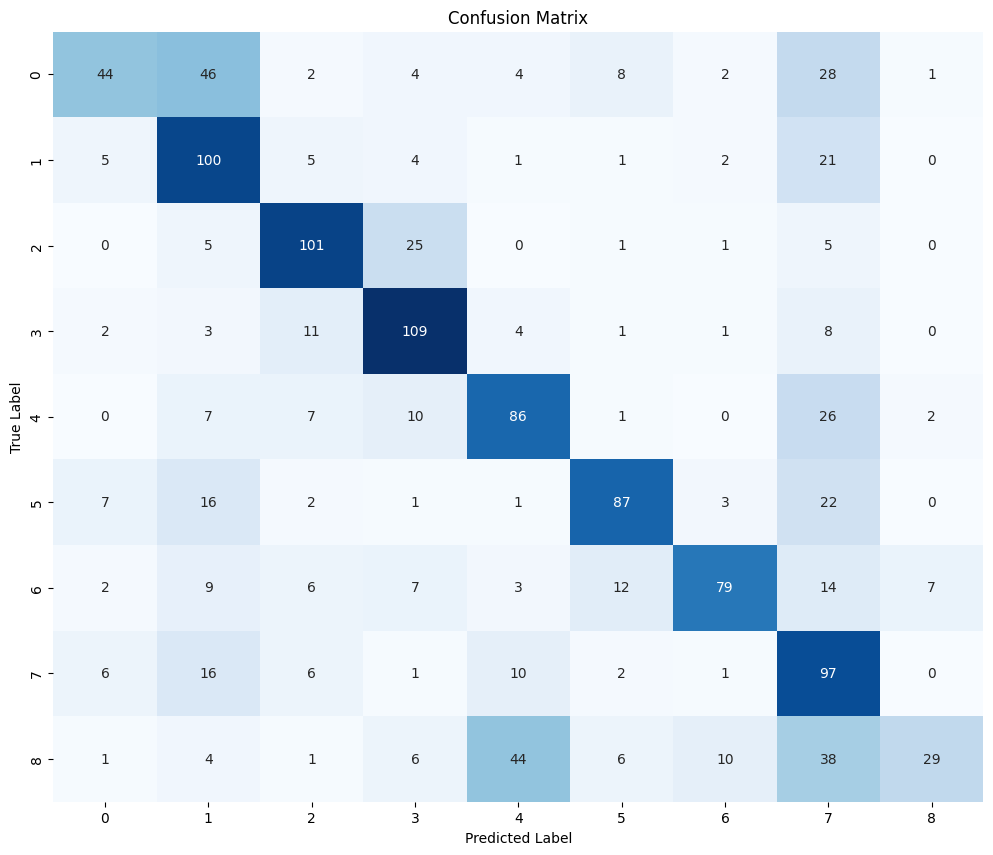

In [16]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = best_model.predict(x_batch)

    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(y_batch.numpy())

plot_confusion_matrix(y_true, y_pred, classes=class_names)

## MobileNet FineTunning

Finally we will try to __finetune the entire MobileNet network__.

We expect this approach to perform better that the simple transfer learning, as we will be finetunning all the model parameters and not only the classification head.

Here, it's common to use a small learning rate.

__We will use the optimal model from the search above__, with a classification head of size `128`.

We first have to re-load the dataset with a smaller batch size, for example: `4`

In [2]:
train_dataset_path = "../../sign_datasets/kslc-kenyan-sign-language-dataset/train"
test_dataset_path = "../../sign_datasets/kslc-kenyan-sign-language-dataset/test"

train_dataset, val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset_path,
    # No resize needed, image is already 224, 244
    image_size=(224, 224),
    batch_size=4,
    validation_split=0.15,
    shuffle=True,
    seed=42,
    subset="both",
)

# The test dataset is under the test folder
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset_path,
    # No resize needed, image is already 224, 244
    image_size=(224, 224),
    batch_size=4,
    shuffle=True,
)


def normalize_image(image, label):
    precomputed_mean = [0.6287722587585449, 0.6092960834503174, 0.5825445055961609]
    precomputed_std = [0.6499956250190735, 0.6389758586883545, 0.6195625066757202]

    # Normalize the image
    image = (image / 255.0 - precomputed_mean) / precomputed_std
    return image, label


train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

print(
    f"Train size: {train_dataset.cardinality().numpy()}. Validation size will be: {val_dataset.cardinality().numpy()}"
)

# Set performance settings
# Prefetch one batch at a time
buffer_size = 1
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
val_dataset = val_dataset.prefetch(buffer_size=buffer_size)
test_dataset = test_dataset.prefetch(buffer_size=buffer_size)


Found 4999 files belonging to 9 classes.
Using 4250 files for training.
Using 749 files for validation.


I0000 00:00:1738826092.295602    1194 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2859 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Found 1250 files belonging to 9 classes.
Train size: 1063. Validation size will be: 188


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,625 (9.25 MB)

 Trainable params: 2,389,257 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)

None
Epoch 1/10
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 115s 71ms/step - accuracy: 0.3000 - loss: 2.0915 - val_accuracy: 0.7704 - val_loss: 0.7186
Epoch 2/10
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 56s 52ms/step - accuracy: 0.7007 - loss: 0.9654 - val_accuracy: 0.8531 - val_loss: 0.4759
Epoch 3/10
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 56s 52ms/step - accuracy: 0.7766 - loss: 0.7481 - val_accuracy: 0.8585 - val_loss: 0.4582
Epoch 4/10
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 56s 53ms/step - accuracy: 0.8333 - loss: 0.5911 - val_accuracy: 0.8892 - val_loss: 0.3650
Epoch 5/10
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 56s 53ms/step - accuracy: 0.8562 - loss: 0.5175 - val_accuracy: 0.8745 - val_loss: 0.4528
Epoch 6/10
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 57s 53ms/step - accuracy: 0.8624 - loss: 0.4806 - val_accuracy: 0.8879 - val_loss: 0.3907
Epoch 7/10
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 56s 53ms/step - accuracy: 0.8823 - loss: 0.4211 - val_accuracy: 0.8785 - val_loss: 0.4105


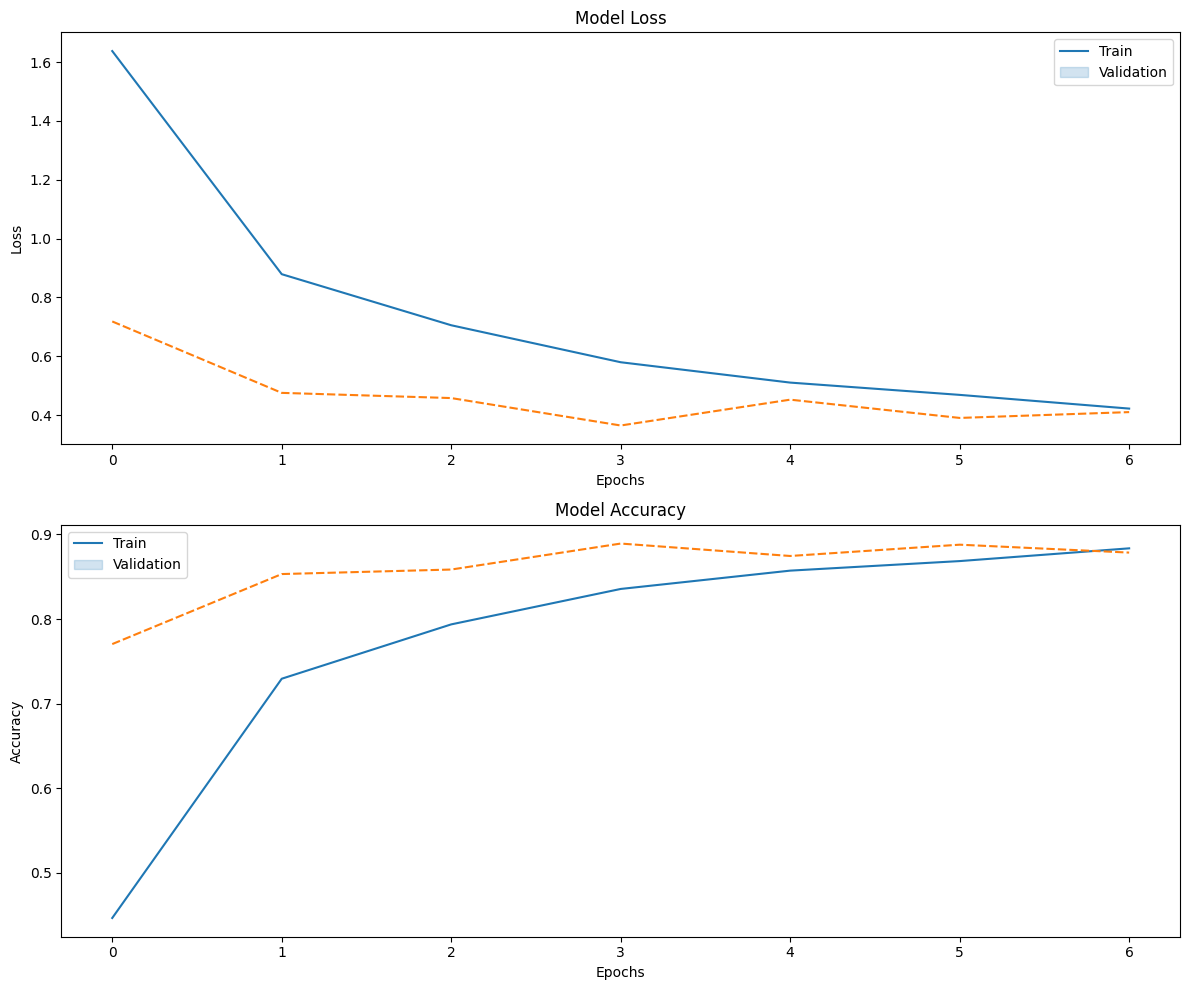

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8785 - loss: 0.4015
Test Loss: 0.3716394901275635
Test Accuracy: 0.8871999979019165


In [7]:
HIDDEN_SIZE = 128

# early stopping callback
# patience of 3 since we have a small number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",  # Metric to monitor
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
)


base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet"
)
# WE WANT to train the entire model
base_model.trainable = True


# Add custom layers on top of the base model
model = tf.keras.Sequential(
    [
        base_model,
        # This is added to reduce the number of parameters
        tf.keras.layers.GlobalAveragePooling2D(),
        # Add our custom hidden size
        tf.keras.layers.Dense(HIDDEN_SIZE, activation=None),
        # Use a batch normalization layer
        tf.keras.layers.BatchNormalization(),
        # Then the relu
        tf.keras.layers.Activation("relu"),
        # Dropout of 0.4
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(len(class_names), activation="softmax"),
    ]
)

print(model.summary())

# Learning rate is set to 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping]
)

# plot two graphs, one for the train / val loss and one for the train / val accuracy
plot_history(history)


# Finally inference with the best model
results = model.evaluate(test_dataset)

print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

### Confusion Matrix

100%|██████████| 313/313 [00:39<00:00,  8.00it/s]


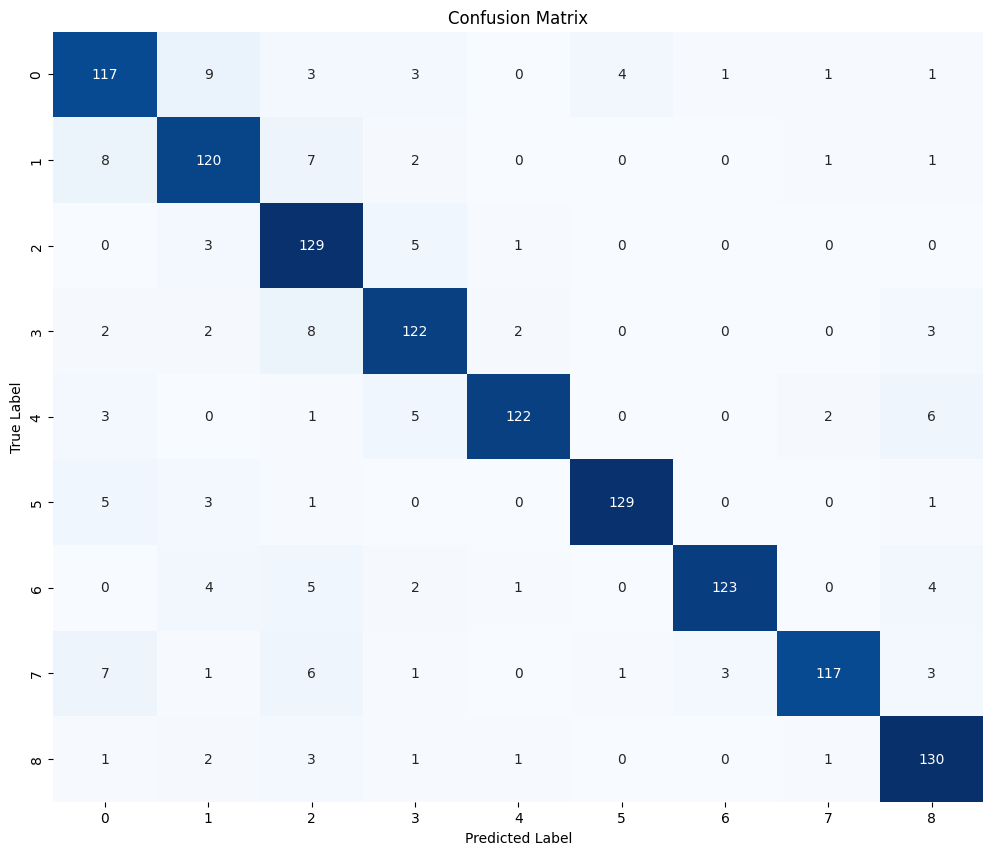

In [8]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = model.predict(x_batch, verbose=0)

    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(y_batch.numpy())

plot_confusion_matrix(y_true, y_pred, classes=class_names)